In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const

In [2]:
%matplotlib notebook

In [3]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project/Exoplanets'
All_stars_directory = f'{Main_directory}/All Stars Data.csv'

All_stars_data = pd.read_csv(All_stars_directory)

def Data_check(Data, headers=False):
    headers = Data.columns if type(headers) is bool else headers 
    bool_array = [pd.notna(Data[col_name]) for col_name in headers]
    check = np.flipud(np.rot90(bool_array))
    return check

def Find_least_error(Data, Checked_data, headers, error_headers, pm_seperation=True):
    least_error_array = []
    for row, boolean in enumerate(Checked_data):
        previous_error = np.inf
        for dataset, error_header in enumerate(error_headers):
            if sum(boolean) == 0:
                lowest_error = False
                break
            if boolean[dataset]:
                if pm_seperation:
                    current_error = Data[error_header[0]][row] + Data[error_header[1]][row]
                else:
                    current_error = 2*Data[error_header][row]
                if current_error < previous_error:
                    previous_error = current_error
                    lowest_error = headers[dataset]
        least_error_array.append(lowest_error)
    return least_error_array

def Ensure_all(All_variables):
    total_info = []
    num_stars = len(All_variables[0])
    for star_index in range(num_stars):
        object_info = [star_index]
        eliminate = False
        for sources in All_variables:
            eliminate = type(sources[star_index]) is bool
            if eliminate:
                break
            object_info.append(sources[star_index])
        if eliminate:
            continue
        total_info.append(object_info)
    return total_info

def Get_filtered_arrays(Data, Filtered_headers):
    Total_data = []
    for row in Filtered_headers:
        row_data = []
        for index in range(1, len(row)):
            row_data.append(Data[row[index]][row[0]])
        Total_data.append(row_data)
    return np.array(Total_data)

In [4]:
Teff_headers = ['Teff (Gaia)', 'Teff (Exo)', 'Teff (Fulton)', 'Teff (Van Eylen)']
Rad_headers = ['Radius (Gaia)', 'Radius (Fulton)', 'Radius (Van Eylen)']

Teff_check = Data_check(All_stars_data, Teff_headers)
Rad_check = Data_check(All_stars_data, Rad_headers)

Teff_error_headers = [['Teff pe (Gaia)', 'Teff me (Gaia)'], 
                      ['Teff pe (Exo)', 'Teff me (Exo)'], 
                      ['Teff pe (Fulton)', 'Teff me (Fulton)'],
                      ['Teff pe (Van Eylen)', 'Teff me (Van Eylen)']]

Rad_error_headers = [['Rad pe (Gaia)', 'Rad me (Gaia)'],
                     ['Rad pe (Fulton)', 'Rad me (Fulton)'],
                     ['Rad pe (Van Eylen)', 'Rad me (Van Eylen)']]
            
Best_teff_sources = Find_least_error(All_stars_data, Teff_check, Teff_headers, Teff_error_headers)
Best_rad_sources = Find_least_error(All_stars_data, Rad_check, Rad_headers, Rad_error_headers)

All_info = [Best_teff_sources, Best_rad_sources]
Filtered_headers = Ensure_all(All_info)

<IPython.core.display.Javascript object>


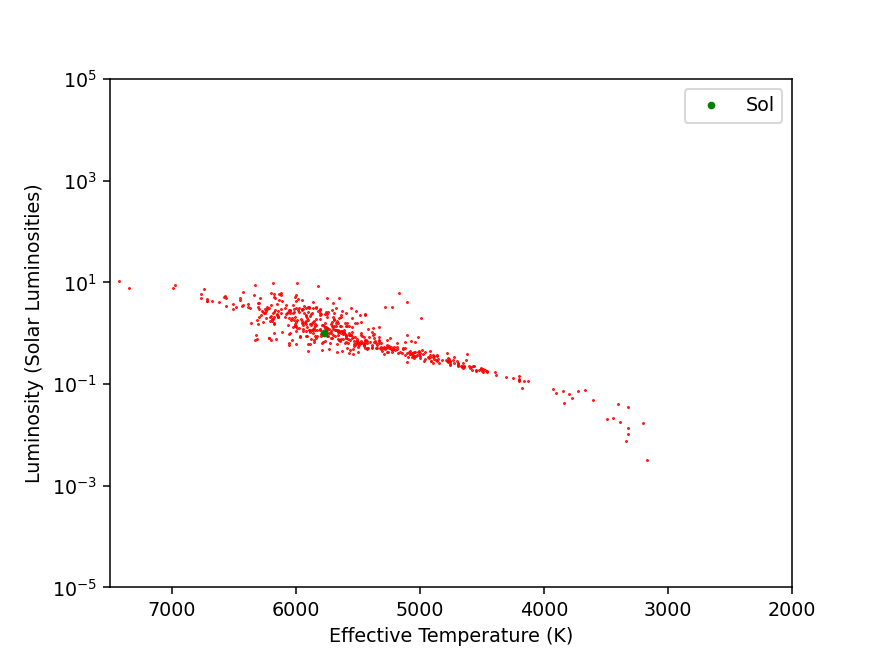

In [9]:
Array = Get_filtered_arrays(All_stars_data, Filtered_headers)
Teff = Array[:,0]
Rad = Array[:,1]
Luminosity = Rad**2*(Teff/5772)**4

plt.figure()
plt.plot(Teff, Luminosity, 'r.', markersize=1)
plt.plot(5772, 1, 'g.', label='Sol')
plt.ylabel('Luminosity (Solar Luminosities)')
plt.xlabel('Effective Temperature (K)')
plt.xlim(2000, 7500)
plt.ylim(0.00001, 100000)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.legend()
plt.show()